In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast  # for safely evaluating strings as literals

In [3]:
# Load the CSV file
try:
    df = pd.read_csv('training-data-series-1728643356800140700.csv', delimiter=";")
except Exception as e:
    print(f"An unexpected error occurred while loading the CSV file: {str(e)}")
    print("Make sure the file exists and is not corrupted. Check if padding is activated in your config.")

In [4]:
# The last two columns are num_included and num_excluded
y = df.iloc[:, -2:]
y.columns = ['num_included', 'num_excluded']

# Extract X (the first column, which contains multiple cascade bitstrings)
X = df.iloc[:, 0].str.split(',', expand=True).values.tolist()

# Convert the list of lists to a list of strings
X = [''.join(row) for row in X]

In [5]:
def summarize_X(X):
    num_samples = len(X)
    
    if num_samples > 0:
        first_bitstring_length = len(X[0])
        all_same_length = all(len(bitstring) == first_bitstring_length for bitstring in X)
        
        print(f"Bistring Cascade Dataset Summary:")
        print(f"Number of samples: {num_samples}")
        print(f"Length of each bitstring: {first_bitstring_length}")
        
        if not all_same_length:
            print("Warning: Not all bitstrings have the same length!")
    else:
        print("X Dataset is empty.")

def summarize_Y(y):
    print("\nInvocation Dataset Summary:")
    print(y.describe())

# Run the summaries
summarize_X(X)
summarize_Y(y)

Bistring Cascade Dataset Summary:
Number of samples: 1000
Length of each bitstring: 336

Invocation Dataset Summary:
       num_included  num_excluded
count    1000.00000   1000.000000
mean       51.18100     50.242000
std        28.34932     29.114964
min         1.00000      1.000000
25%        29.00000     23.000000
50%        49.00000     52.000000
75%        76.00000     76.000000
max       100.00000    100.000000


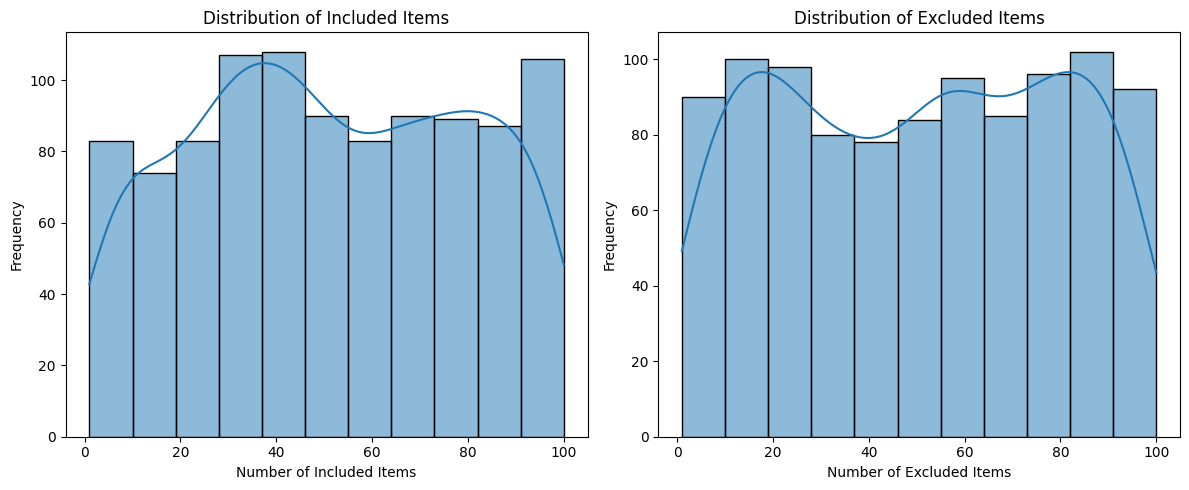

In [6]:
def plot_y_distributions(y):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(y['num_included'], kde=True)
    plt.title('Distribution of Included Items')
    plt.xlabel('Number of Included Items')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    sns.histplot(y['num_excluded'], kde=True)
    plt.title('Distribution of Excluded Items')
    plt.xlabel('Number of Excluded Items')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Assuming y is already defined
plot_y_distributions(y)

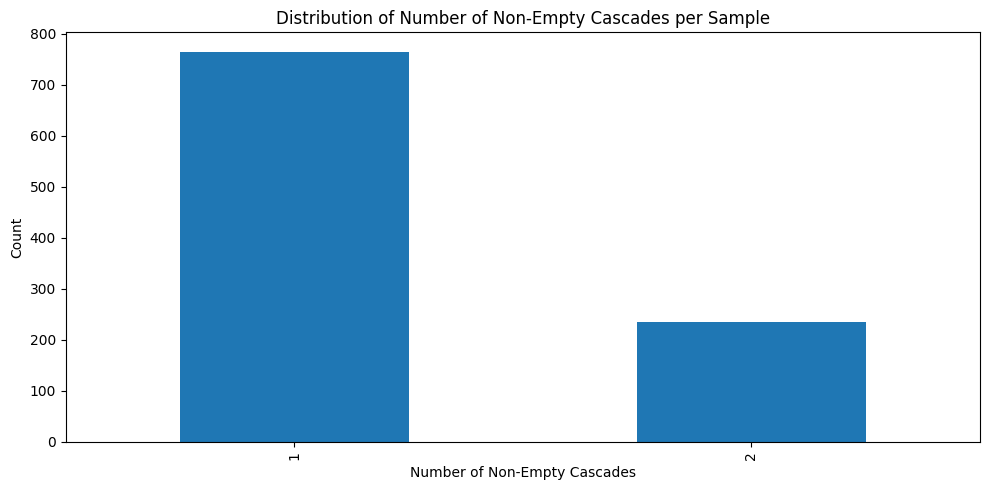

In [12]:
def analyze_non_empty_cascades(df):
    # Function to count non-empty cascades in a sample
    def count_non_empty_cascades(sample):
        cascades = sample.split(',')
        return sum(1 for cascade in cascades if cascade.strip() != '0'*len(cascade.strip()))
    
    # Count non-empty cascades for each sample
    non_empty_counts = df.iloc[:, 0].apply(count_non_empty_cascades)
    
    # Create a Series of non-empty cascade counts
    cascade_counts = non_empty_counts.value_counts().sort_index()
    
    # Create a bar plot
    plt.figure(figsize=(10, 5))
    cascade_counts.plot(kind='bar')
    plt.title('Distribution of Number of Non-Empty Cascades per Sample')
    plt.xlabel('Number of Non-Empty Cascades')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Assuming df is your original DataFrame
analyze_non_empty_cascades(df)

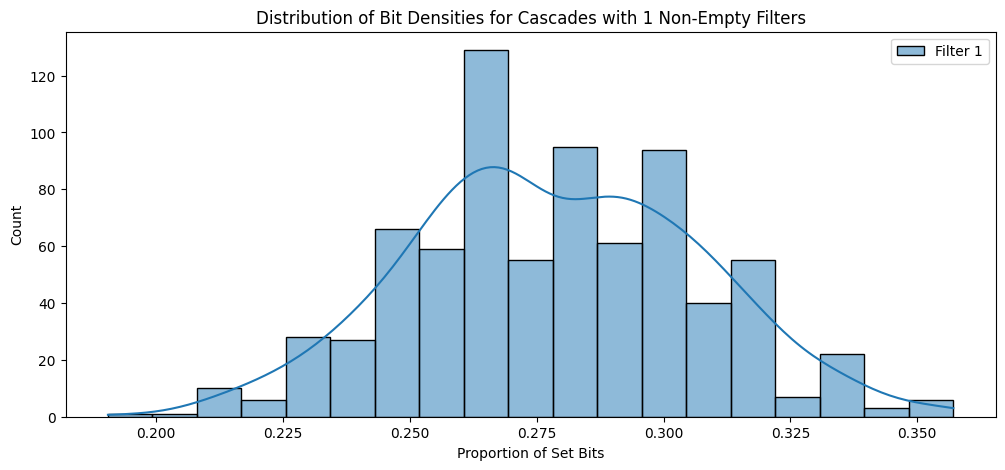

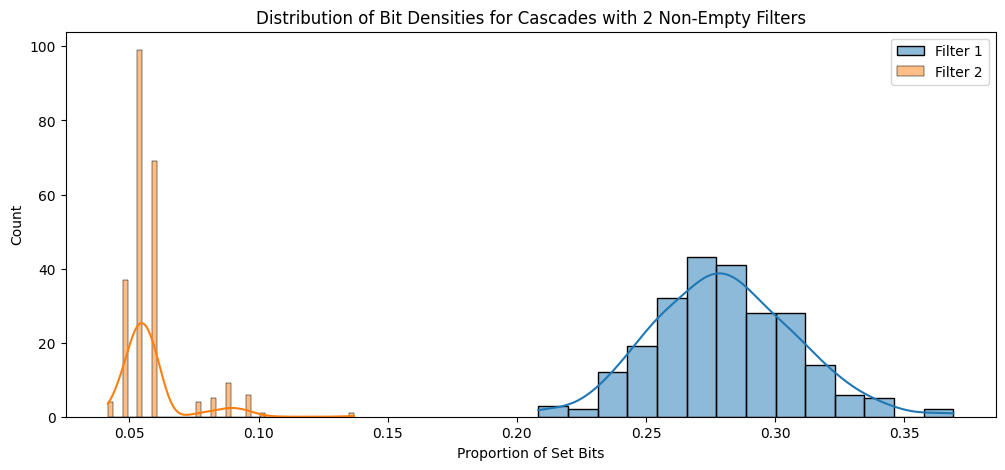

In [15]:
def visualize_non_empty_bit_densities(df):
    def calculate_bit_density(bitstring):
        return bitstring.count('1') / len(bitstring) if '1' in bitstring else None

    # Calculate bit densities for each non-empty filter in each sample
    bit_densities = df.iloc[:, 0].apply(lambda x: [calculate_bit_density(filter.strip()) 
                                                   for filter in x.split(',') if '1' in filter])
    
    # Get number of non-empty filters for each sample
    num_filters = bit_densities.apply(lambda x: len([d for d in x if d is not None]))
    
    max_filters = num_filters.max()

    # Plot bit densities for each filter position, separated by number of filters
    for n in range(1, max_filters + 1):
        densities_n_filters = [densities for densities, num in zip(bit_densities, num_filters) if num == n]
        if densities_n_filters:
            plt.figure(figsize=(12, 5))
            for i in range(n):
                filter_densities = [d[i] for d in densities_n_filters if i < len(d)]
                if filter_densities:
                    sns.histplot(filter_densities, kde=True, label=f'Filter {i+1}')
            plt.title(f'Distribution of Bit Densities for Cascades with {n} Non-Empty Filters')
            plt.xlabel('Proportion of Set Bits')
            plt.ylabel('Count')
            plt.legend()
            plt.show()

# Assuming df is your original DataFrame
visualize_non_empty_bit_densities(df)

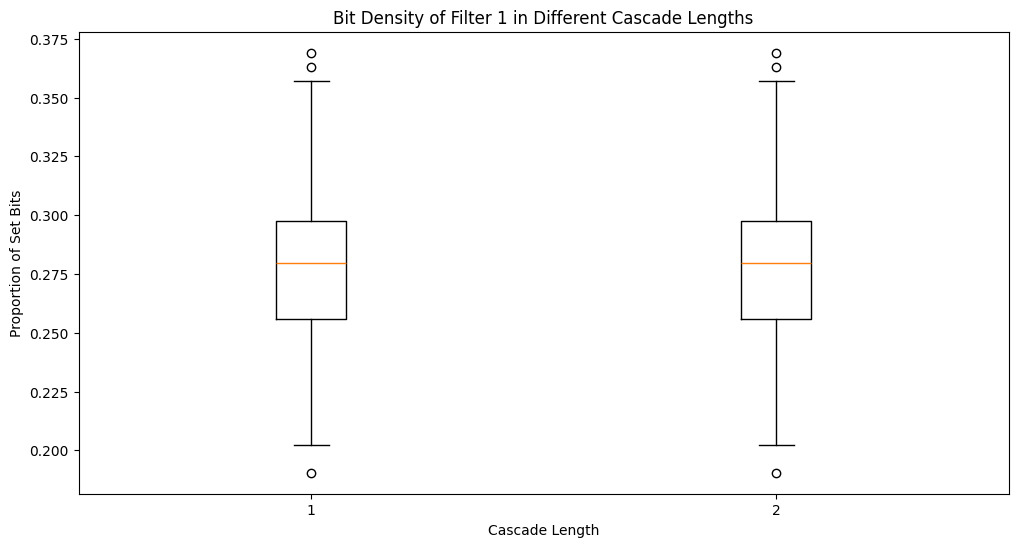

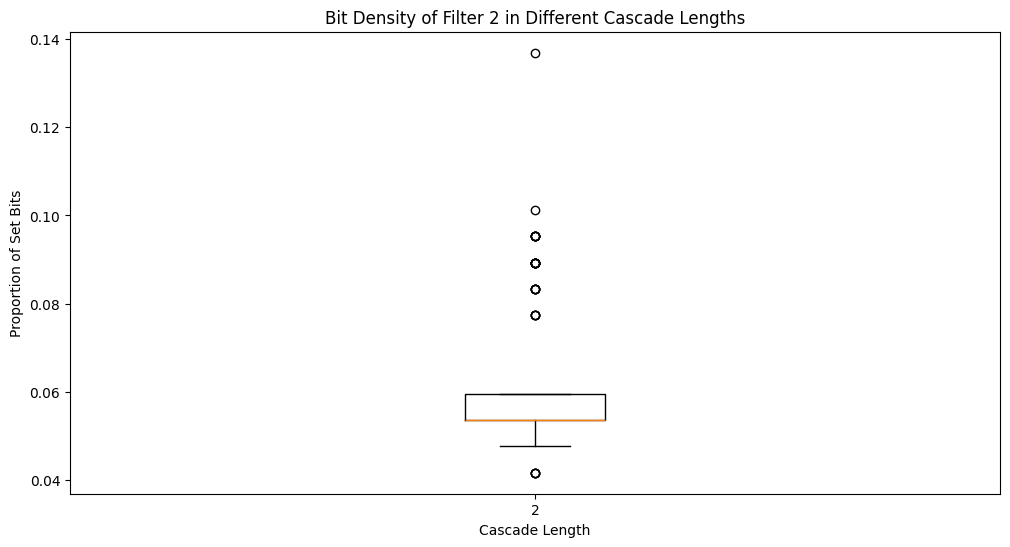

In [16]:
def compare_filter_position_bit_densities(df):
    def calculate_bit_density(bitstring):
        return bitstring.count('1') / len(bitstring) if '1' in bitstring else None

    # Calculate bit densities for each filter in each sample
    bit_densities = df.iloc[:, 0].apply(lambda x: [calculate_bit_density(filter.strip()) 
                                                   for filter in x.split(',')])
    
    # Get number of filters for each sample
    num_filters = bit_densities.apply(lambda x: len([d for d in x if d is not None]))
    
    max_filters = num_filters.max()

    # Compare specific filter positions across different cascade lengths
    for filter_pos in range(max_filters):
        densities_by_cascade = [
            [densities[filter_pos] for densities, num in zip(bit_densities, num_filters) 
             if num > filter_pos and densities[filter_pos] is not None]
            for cascade_length in range(filter_pos + 1, max_filters + 1)
        ]
        
        if any(densities_by_cascade):
            plt.figure(figsize=(12, 6))
            plt.boxplot(densities_by_cascade)
            plt.title(f'Bit Density of Filter {filter_pos + 1} in Different Cascade Lengths')
            plt.xlabel('Cascade Length')
            plt.ylabel('Proportion of Set Bits')
            plt.xticks(range(1, len(densities_by_cascade) + 1), 
                       [str(i) for i in range(filter_pos + 1, max_filters + 1)])
            plt.show()

# Assuming df is your original DataFrame
compare_filter_position_bit_densities(df)

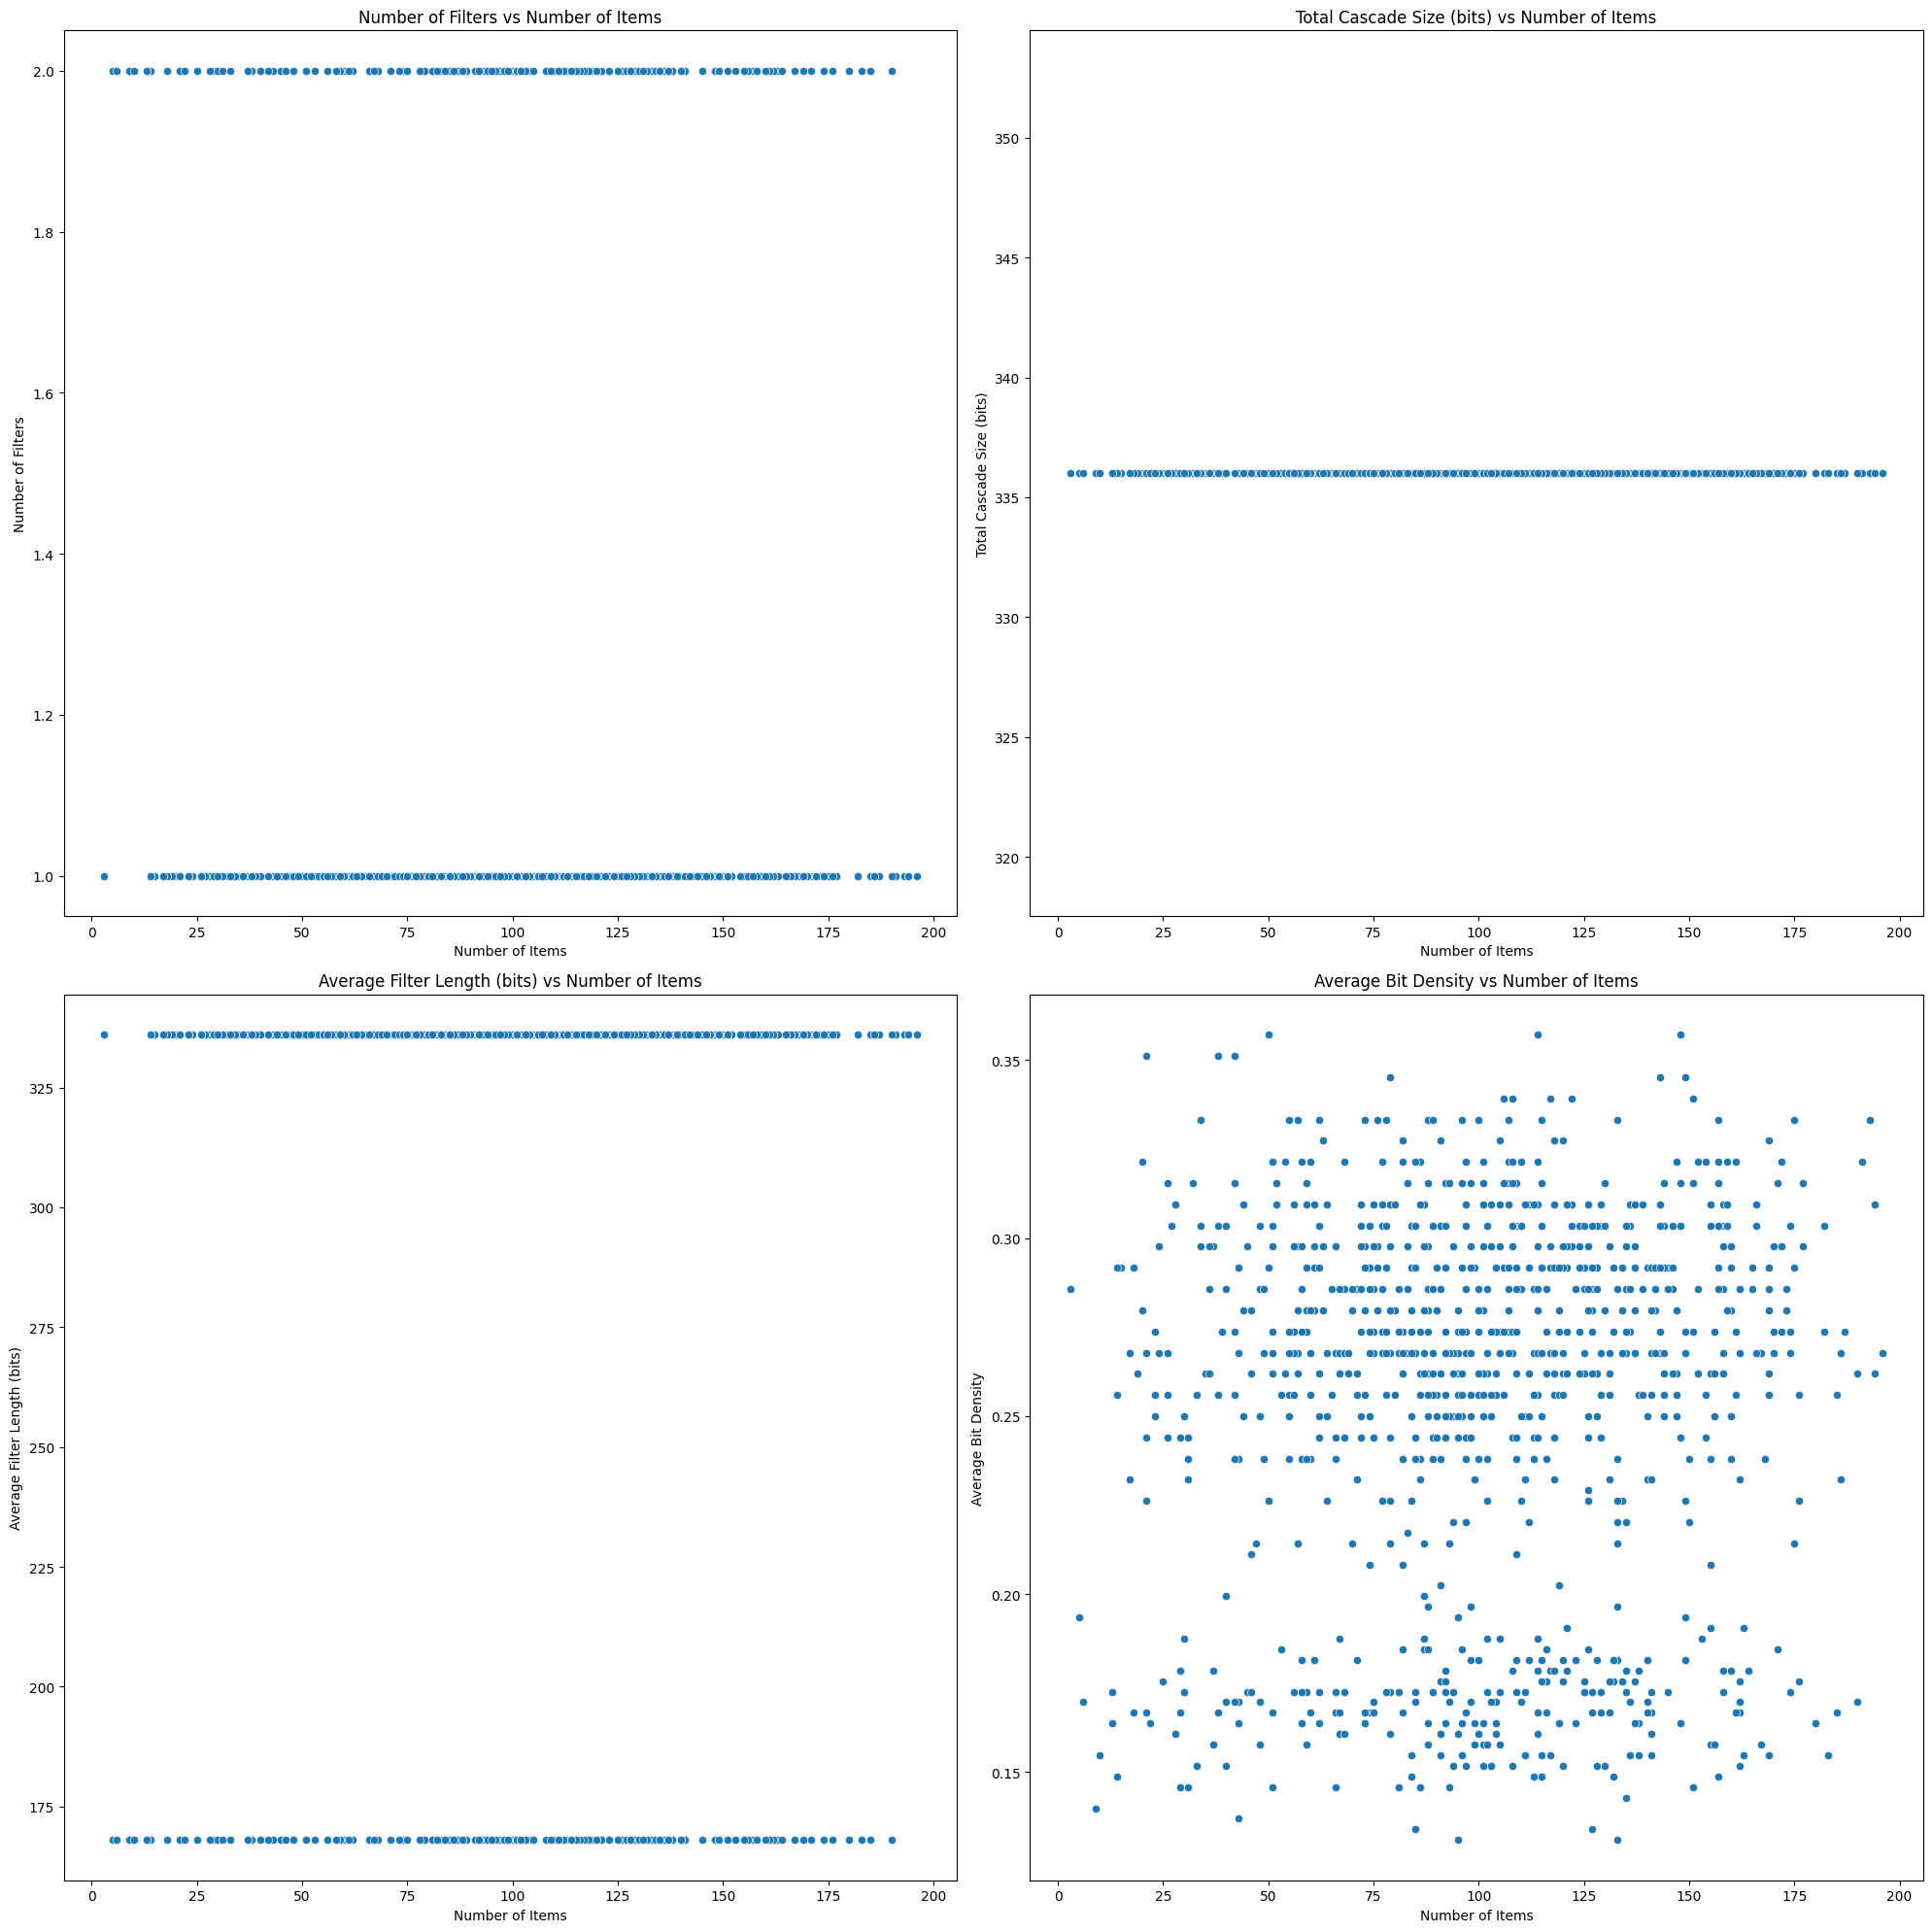

In [17]:
def analyze_cascade_relationships(df):
    # Extract y data
    df_y = df.iloc[:, -2:].copy()
    df_y.columns = ['num_included', 'num_excluded']
    
    # Calculate additional metrics
    df_y['total_items'] = df_y['num_included'] + df_y['num_excluded']
    
    def process_cascade(cascade):
        filters = cascade.split(',')
        num_filters = len([f for f in filters if '1' in f])
        total_size = sum(len(f.strip()) for f in filters)
        avg_length = total_size / num_filters if num_filters > 0 else 0
        bit_densities = [f.count('1') / len(f) for f in filters if '1' in f]
        avg_density = np.mean(bit_densities) if bit_densities else 0
        return num_filters, total_size, avg_length, avg_density

    cascades = df.iloc[:, 0]
    processed_data = cascades.apply(process_cascade)
    
    df_y['num_filters'], df_y['total_cascade_size'], df_y['avg_filter_length'], df_y['avg_bit_density'] = zip(*processed_data)

    relationships = [
        ('total_items', 'num_filters', 'Number of Items', 'Number of Filters'),
        ('total_items', 'total_cascade_size', 'Number of Items', 'Total Cascade Size (bits)'),
        ('total_items', 'avg_filter_length', 'Number of Items', 'Average Filter Length (bits)'),
        ('total_items', 'avg_bit_density', 'Number of Items', 'Average Bit Density')
    ]

    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    for i, (x, y, x_label, y_label) in enumerate(relationships):
        ax = axes[i // 2, i % 2]
        sns.scatterplot(data=df_y, x=x, y=y, ax=ax)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(f'{y_label} vs {x_label}')
    plt.tight_layout()
    plt.show()

# Assuming df is your original DataFrame
analyze_cascade_relationships(df)